In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
# Load the datasets
hemorrhage_data = pd.read_csv('hemorrhage_diagnosis.csv')
demographics_data = pd.read_csv('patient_demographics.csv')

# Display the first few rows of each dataset
print("Hemorrhage Data:")
print(hemorrhage_data.head())
print("\nDemographics Data:")
print(demographics_data.head())

Hemorrhage Data:
   PatientNumber  SliceNumber  Intraventricular  Intraparenchymal  \
0             49            1                 0                 0   
1             49            2                 0                 0   
2             49            3                 0                 0   
3             49            4                 0                 0   
4             49            5                 0                 0   

   Subarachnoid  Epidural  Subdural  No_Hemorrhage  Fracture_Yes_No  
0             0         0         0              1                0  
1             0         0         0              1                0  
2             0         0         0              1                0  
3             0         0         0              1                0  
4             0         0         0              1                0  

Demographics Data:
   Patient Number  Age\n(years)  Gender  Intraventricular  Intraparenchymal  \
0              49     35.000000    Male          

In [ ]:
# Standardize column names for merging
demographics_data.rename(columns={'Patient Number': 'PatientNumber', 'Age\n(years)': 'Age'}, inplace=True)

# Merge datasets on 'PatientNumber'
data = pd.merge(hemorrhage_data, demographics_data, on='PatientNumber', how='inner')

# Drop unnecessary columns
data = data.drop(columns=['SliceNumber'])

# Fill missing values: categorical columns with mode, numerical with mean
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna(data[column].mode()[0])
    else:
        data[column] = data[column].fillna(data[column].mean())

# Convert categorical variables to numeric
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
data['Fracture (Yes/No)'] = data['Fracture (Yes/No)'].astype(int)

# Check correlations with target variable, ignoring non-numeric columns
numeric_data = data.select_dtypes(include=[np.number])  # Select only numeric columns
correlations = numeric_data.corr()
target_correlations = correlations['No_Hemorrhage'].sort_values(ascending=False)
print("\nFeature Correlations with Target:\n", target_correlations)

# Drop features highly correlated with the target (correlation > 0.8)
high_corr_features = target_correlations[target_correlations > 0.8].index.drop('No_Hemorrhage')
data = data.drop(columns=high_corr_features)


Feature Correlations with Target:
 No_Hemorrhage         1.000000
PatientNumber         0.247143
Age                   0.081778
Gender               -0.194336
Subarachnoid_x       -0.223080
Intraventricular_x   -0.257903
Subdural_x           -0.396523
Fracture_Yes_No      -0.430654
Intraparenchymal_x   -0.454308
Epidural_x           -0.714241
Intraventricular_y         NaN
Intraparenchymal_y         NaN
Subarachnoid_y             NaN
Epidural_y                 NaN
Subdural_y                 NaN
Fracture (Yes/No)          NaN
Name: No_Hemorrhage, dtype: float64


In [ ]:
# Step 1: Check for class imbalance
class_distribution = data['No_Hemorrhage'].value_counts()
print("Class Distribution:\n", class_distribution)

# Step 2: Check correlations with target variable, ignoring non-numeric columns
numeric_data = data.select_dtypes(include=[np.number])  # Select only numeric columns
correlations = numeric_data.corr()
target_correlations = correlations['No_Hemorrhage'].sort_values(ascending=False)
print("\nFeature Correlations with Target:\n", target_correlations)

# Drop features that are highly correlated with the target (correlation > 0.8, for instance)
high_corr_features = target_correlations[target_correlations > 0.8].index.drop('No_Hemorrhage')
data = data.drop(columns=high_corr_features)

Class Distribution:
 No_Hemorrhage
1    2183
0     318
Name: count, dtype: int64

Feature Correlations with Target:
 No_Hemorrhage         1.000000
PatientNumber         0.247143
Age                   0.081778
Gender               -0.194336
Subarachnoid_x       -0.223080
Intraventricular_x   -0.257903
Subdural_x           -0.396523
Fracture_Yes_No      -0.430654
Intraparenchymal_x   -0.454308
Epidural_x           -0.714241
Intraventricular_y         NaN
Intraparenchymal_y         NaN
Subarachnoid_y             NaN
Epidural_y                 NaN
Subdural_y                 NaN
Fracture (Yes/No)          NaN
Name: No_Hemorrhage, dtype: float64


In [ ]:
# Define features (X) and target (y)
X = data.drop(columns=['No_Hemorrhage', 'PatientNumber', 'Condition on file', 'Note'])
y = data['No_Hemorrhage']

In [ ]:
# Initialize models with regularized parameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=0.5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5),
    'Support Vector Machine': SVC(probability=True, C=0.5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, n_estimators=100, max_depth=3)
}

# Define a function to create a neural network model
def create_nn_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = {model_name: {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
           for model_name in models.keys()}
metrics['Neural Network'] = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

# Train and evaluate each model using cross-validation
for model_name, model in models.items():
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit model and make predictions
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Calculate accuracy
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Calculate log loss
        y_train_prob = model.predict_proba(X_train)
        y_val_prob = model.predict_proba(X_val)
        train_loss = log_loss(y_train, y_train_prob)
        val_loss = log_loss(y_val, y_val_prob)

        # Store metrics
        metrics[model_name]['train_accuracy'].append(train_accuracy)
        metrics[model_name]['val_accuracy'].append(val_accuracy)
        metrics[model_name]['train_loss'].append(train_loss)
        metrics[model_name]['val_loss'].append(val_loss)

# Train and evaluate the Neural Network separately
input_dim = X.shape[1]
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Build and train the neural network model with early stopping
    nn_model = create_nn_model(input_dim)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    nn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_val, y_val),
                 callbacks=[early_stopping])

    # Evaluate on training and validation sets
    train_loss, train_accuracy = nn_model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_accuracy = nn_model.evaluate(X_val, y_val, verbose=0)

    # Store metrics
    metrics['Neural Network']['train_accuracy'].append(train_accuracy)
    metrics['Neural Network']['val_accuracy'].append(val_accuracy)
    metrics['Neural Network']['train_loss'].append(train_loss)
    metrics['Neural Network']['val_loss'].append(val_loss)

In [ ]:
# Calculate average metrics for each model
average_metrics = {model_name: {metric: np.mean(scores) for metric, scores in metric_dict.items()}
                   for model_name, metric_dict in metrics.items()}

# Output metrics values for each model
print("\nModel Performance Metrics (Averaged over Cross-Validation):")
for model_name, metric_dict in average_metrics.items():
    print(f"\n{model_name}:")
    for metric, score in metric_dict.items():
        print(f"  {metric}: {score:.4f}")


Model Performance Metrics (Averaged over Cross-Validation):

Logistic Regression:
  train_loss: 0.0459
  val_loss: 0.0482
  train_accuracy: 0.9931
  val_accuracy: 0.9928

Random Forest:
  train_loss: 0.0669
  val_loss: 0.0682
  train_accuracy: 1.0000
  val_accuracy: 1.0000

Support Vector Machine:
  train_loss: 0.0708
  val_loss: 0.0778
  train_accuracy: 0.8729
  val_accuracy: 0.8729

Gradient Boosting:
  train_loss: 0.0013
  val_loss: 0.0013
  train_accuracy: 1.0000
  val_accuracy: 1.0000

XGBoost:
  train_loss: 0.0051
  val_loss: 0.0102
  train_accuracy: 0.9996
  val_accuracy: 0.9984

Neural Network:
  train_loss: 0.0000
  val_loss: 0.0000
  train_accuracy: 1.0000
  val_accuracy: 1.0000


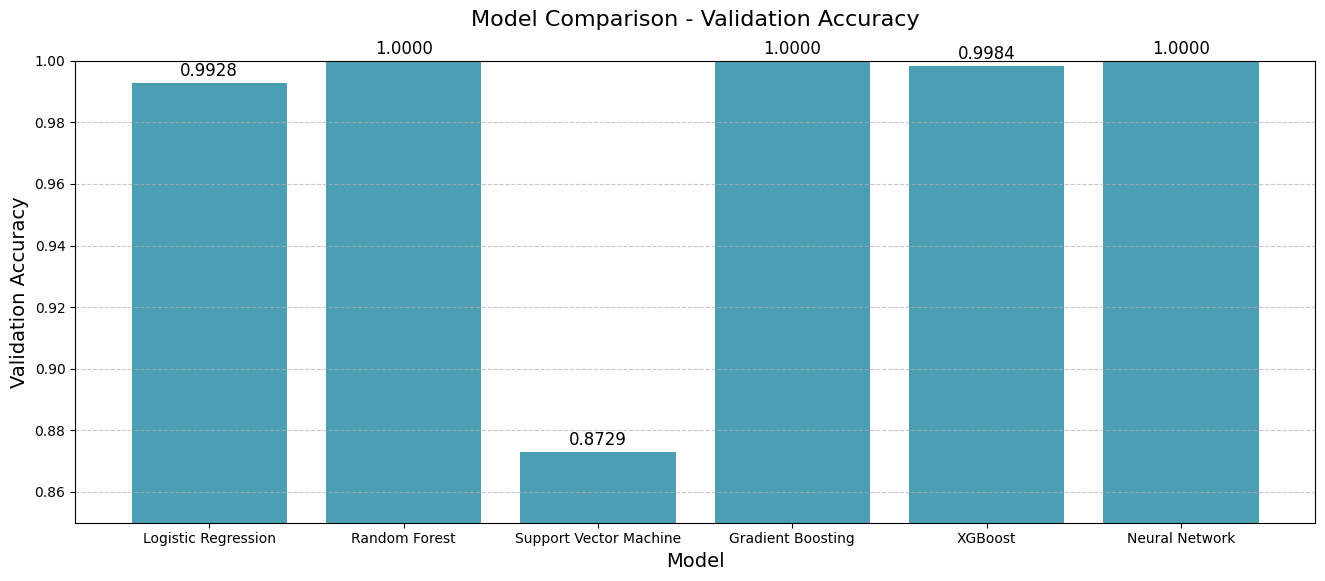

In [ ]:
plt.figure(figsize=(16, 6))
color = '#007594'  # Set the color for all bars

for i, (model_name, metric_dict) in enumerate(average_metrics.items()):
    plt.bar(model_name, metric_dict['val_accuracy'], color=color, alpha=0.7)
    plt.text(i, metric_dict['val_accuracy'] + 0.001, f"{metric_dict['val_accuracy']:.4f}",
             ha='center', va='bottom', fontsize=12)  # Add accuracy label above each bar

# Enhancements for the plot
plt.title('Model Comparison - Validation Accuracy', fontsize=16, pad=25)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.ylim(0.85, 1)  # Set a narrower range for the y-axis to focus on the accuracy range
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for easier comparison

plt.show()

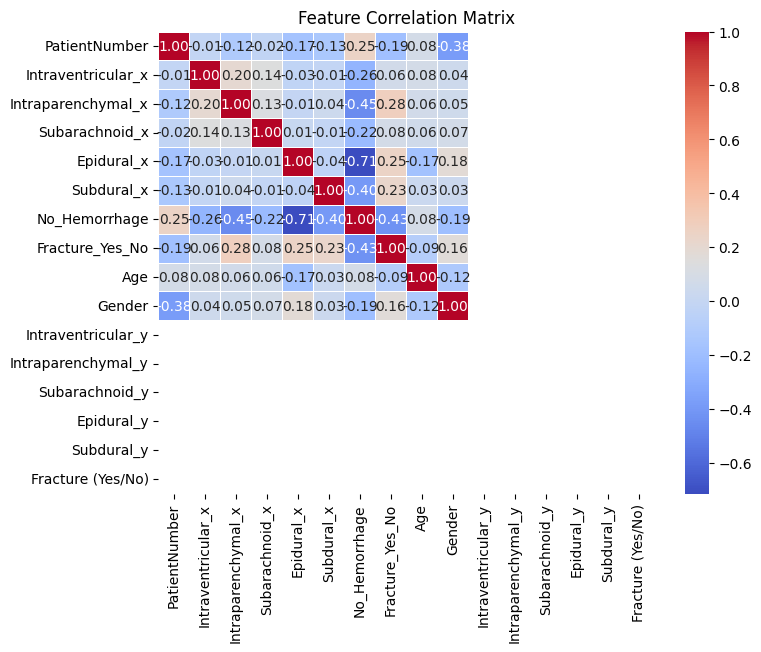

In [ ]:
#Feature Correlation Matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:

import pandas as pd

from tabulate import tabulate

# Define the data for the table
data = {
    "Model": ["Logistic Regression", "Random Forest", "SVM", "Gradient Boosting", "XGBoost", "Neural Network"],
    "Accuracy (%)": [99.28, 100.00, 87.29, 100.00, 99.84, 100.00],
    "Log Loss": [0.0481, 0.0682, 0.0778, 0.0013, 0.0102, 0.0369]
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Display the table in a formatted grid style
from IPython.display import display
display(df.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]},
     {'selector': 'td', 'props': [('text-align', 'center')]}]
).set_caption("Model Performance Comparison"))


,Model,Accuracy (%),Log Loss
0,Logistic Regression,99.280000,0.048100
1,Random Forest,100.000000,0.068200
2,SVM,87.290000,0.077800
3,Gradient Boosting,100.000000,0.001300
4,XGBoost,99.840000,0.010200
5,Neural Network,100.000000,0.036900
